Imports

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.sparse.linalg import eigsh
import umap
from scipy.cluster import hierarchy
import hdbscan

from sklearn.preprocessing import StandardScaler

np.random.seed(1)

Variable Descriptions

In [26]:
# Mortgage              = Total Home Mortgage Balance Amount  
# Card Utilization      = Ratio of Credit Card balances to max limit 
# Amount Past Due       = Total Amount Past Due 

# Card Balance          = Overall Credit Card balances in current month 
# Card Balance_nm       = Overall Credit Card balances in the last n months

# Credit Inquiry        = Total number of inquiries made in current month
# Credit Inquiry_nm     = Total number of inquiries made in the last n months

# Open Trade*           = Total number of open trades presently satisfactory reported in current 
#                           month and trades are opened 12 months or older 
# Open Trade_nm         = Total number of open trades presently satisfactory reported in the last n 
#                           months and trades are opened 12 months or older 


# Delinquency Status    = Total number of trades ever derogatory including collections 
#                           (excluding satisfied medical collections) 
# Delinquency Status_nm = Total number of trades ever derogatory including collections (excluding 
#                           satisfied medical collections) in the last n months

# DDA Balance_9m        = Minimum DDA Balances with XYZ bank in last 9 months 
#                           DDA stands for Demand Deposit Accounts such as checking and saving accounts 

# Gender                = 1 if gender is Male and 0 else
# Race                  = 1 if race is White and 0 else
# Race Category         = Race by category 

# Status                = 1 Never delinquent or at most 29 consecutive days 
#                           past due in the last 24 months and 0 else

# WE HAVE NUMERIC, LAGGED NUMERIC, AND DEMOGRAPHIC DATA TO PERFORM BINARY CLASSIFICATION

EDA

In [27]:
data_dir = '../data'
raw, processed = 'raw', 'processed'

train_fname = 'train_PresSE_SRF_747.csv'
test_fname = 'test_PresSE_SRF_747.csv'

train = pd.read_csv(f'{data_dir}/{processed}/{train_fname}')

In [28]:
train['race_category'].value_counts()

race_category
White       9088
Hispanic    6002
Black       2872
Asian       1080
Unknown      958
Name: count, dtype: int64

In [29]:
train[['mortgage', 'amount_past_due', 'dda_balance_9m', 'card_balance']].describe().T.iloc[:, 1:].round(2)

,mean,std,min,25%,50%,75%,max
mortgage,222327.30,92847.40,108212.11,156268.62,194104.62,261449.09,1.207620e+06
amount_past_due,100265.82,9999747.34,0.00,0.00,0.00,247.15,1.000000e+09
dda_balance_9m,150772.66,12246826.96,0.00,0.00,0.00,0.00,1.000000e+09
card_balance,1237.72,1295.86,2.02,382.33,818.48,1621.15,1.591293e+04


In [30]:
p = .995
for col_name in ('amount_past_due', 'dda_balance_9m'):
    print(f'{ round(p*100, 1) }th percentile for {col_name} is: { np.round( np.quantile(train[col_name], p), 2) }')

99.5th percentile for amount_past_due is: 3934.19
99.5th percentile for dda_balance_9m is: 10709.01


In [31]:
# amount_past_due > $15k or dda_balance_9m > $150K seems unreasonable give the 99.5 %ile values for both
train[(train['amount_past_due'] > 1.5e4) | (train['dda_balance_9m'] > 1.5e5)]

,mortgage,card_utilization,amount_past_due,dda_balance_9m,card_balance,card_balance_3m,card_balance_6m,card_balance_12m,delinquency_status,delinquency_status_3m,...,credit_inquiry_6m,credit_inquiry_12m,open_trade,open_trade_3m,open_trade_6m,open_trade_12m,gender,race,race_category,status
134,330431.07,0.328861,1.000000e+09,0.000000e+00,797.61,1748.72,1803.21,2071.76,0,0,...,4,0,0,0,3,0,1,1,White,1
170,401534.88,0.970481,5.026500e+02,1.000000e+09,3382.68,3005.98,2912.31,2894.05,4,4,...,0,0,1,0,0,0,1,1,White,0
11837,143645.20,0.442902,0.000000e+00,1.000000e+09,163.08,112.44,97.79,128.33,0,0,...,0,7,0,0,0,1,0,0,Hispanic,0
16238,133074.36,0.907160,1.000000e+09,9.445400e+02,789.07,651.09,650.28,377.82,0,0,...,4,4,0,1,1,2,0,0,Black,1
19991,158506.34,0.127750,0.000000e+00,1.000000e+09,128.47,263.44,188.07,130.58,0,0,...,0,7,0,0,0,3,0,0,Unknown,1


In [32]:
# Sample train data includes amounts past due and DDA balances on the order of $1bn.
# Treating this as an error and removing these outliers.
train = train[~((train['amount_past_due'] > 1.5e4) | (train['dda_balance_9m'] > 1.5e5))]

In [33]:
train[train.duplicated()]

,mortgage,card_utilization,amount_past_due,dda_balance_9m,card_balance,card_balance_3m,card_balance_6m,card_balance_12m,delinquency_status,delinquency_status_3m,...,credit_inquiry_6m,credit_inquiry_12m,open_trade,open_trade_3m,open_trade_6m,open_trade_12m,gender,race,race_category,status


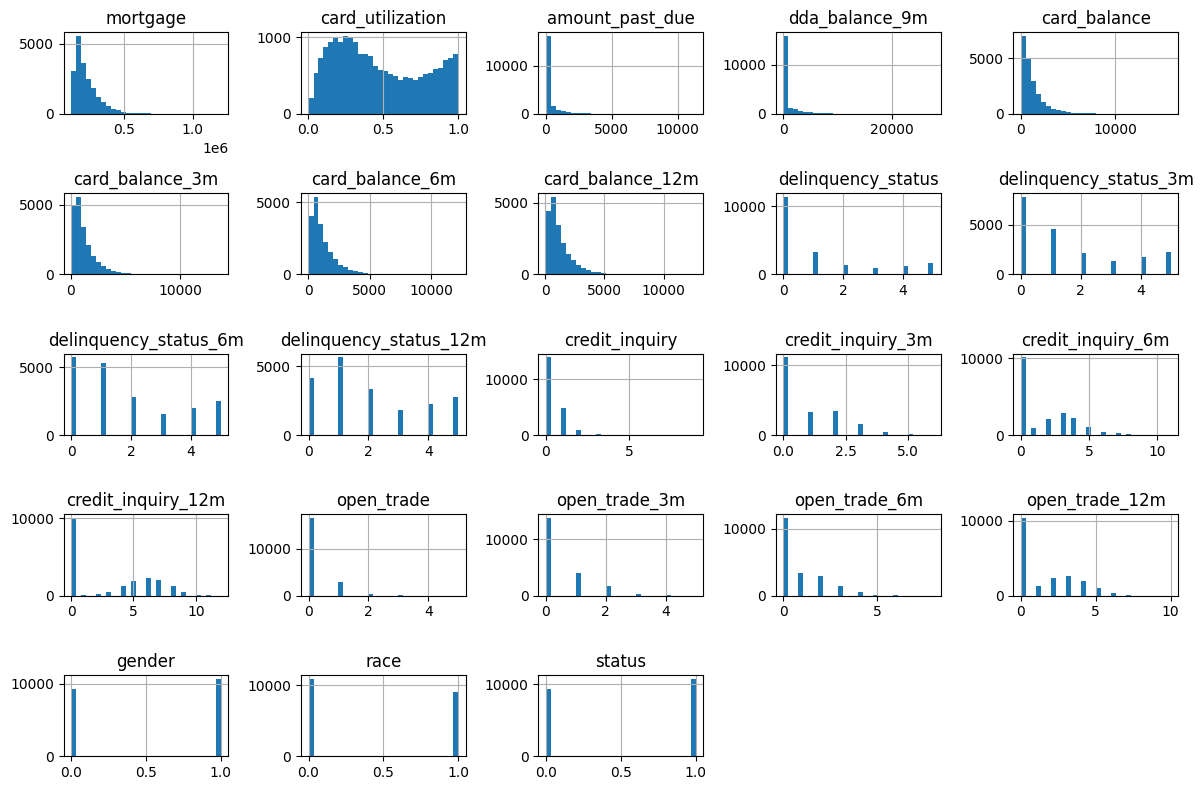

In [34]:
train.hist(bins=30, figsize=(12, 8))
plt.tight_layout()
plt.show()

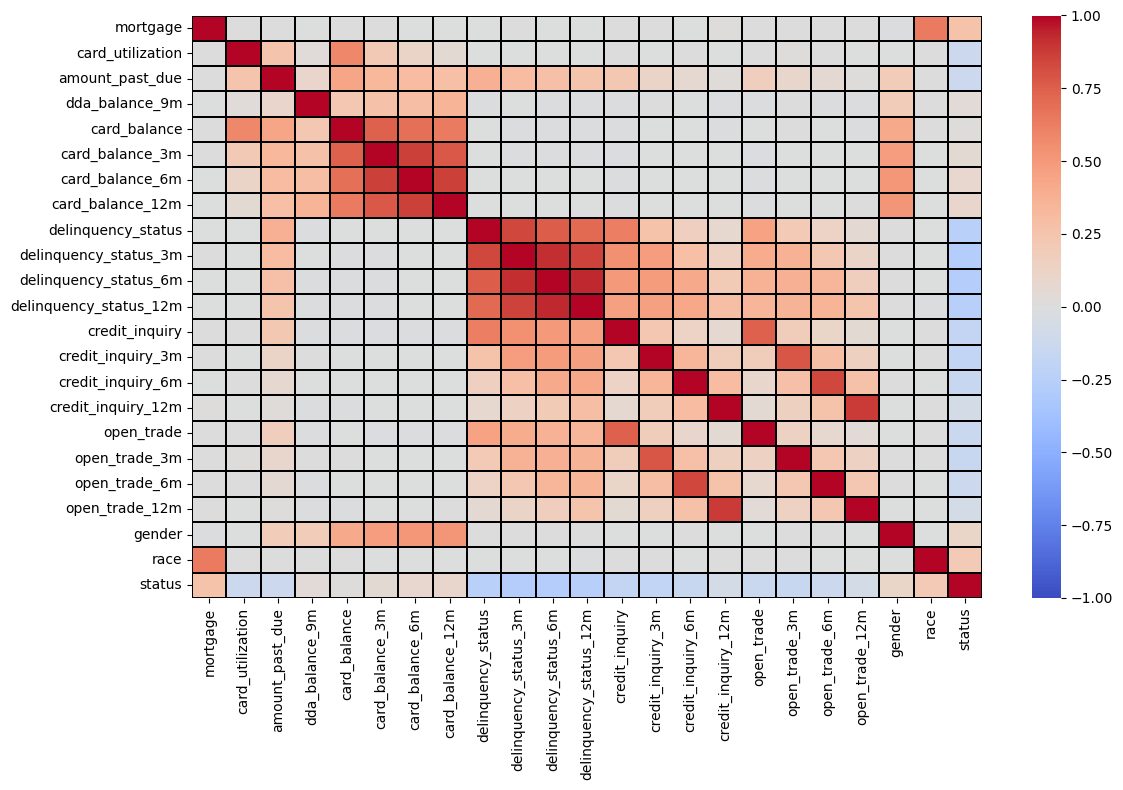

In [35]:
corr_mtx = train.drop('race_category', axis=1).corr()

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
sns.heatmap(corr_mtx, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.01, linecolor='black', ax=ax)

plt.tight_layout()
plt.show()

In [36]:
corr_mtx['status'].sort_values(ascending=False)

status                    1.000000
mortgage                  0.258331
race                      0.204722
gender                    0.109261
card_balance_12m          0.093394
card_balance_6m           0.078222
card_balance_3m           0.054213
dda_balance_9m            0.039010
card_balance              0.012405
open_trade_12m           -0.073391
credit_inquiry_12m       -0.077696
amount_past_due          -0.125315
open_trade_6m            -0.125396
card_utilization         -0.131218
open_trade               -0.133383
open_trade_3m            -0.150071
credit_inquiry_6m        -0.153912
credit_inquiry           -0.176661
credit_inquiry_3m        -0.184851
delinquency_status       -0.242673
delinquency_status_12m   -0.254486
delinquency_status_6m    -0.267621
delinquency_status_3m    -0.269050
Name: status, dtype: float64

In [37]:
# DO ALL EDA PLOTS HERE BEFORE THE SANDBOX WHEN WE ACTUALLY FEATURE ENGINEER!!!
# INTUITION (NEED PLOTS TO PROVE):
# HIGH MORTGAGE AND CREDIT LIMIT + RACE AND GENDER = GOOD CREDIT
# HIGH UTIL, AMT PAST DUE + CREDIT INQUIRIES, OPENING ACCOUNTS, AND DELINQ. STATUS = BAD CREDIT



# Status (1, good) somewhat correlated with:
#   Race, Gender, Card Balance, DDA Balance_9m, Mortgage
#       => proxies for wealth and solvency

# Status (1, good) somewhat anticorrelated with:
#   Delinquency Status
#       => prior delinquency predicts future delinquency?

#   Credit Inquiry, Open Trade
#       => opening many different accounts to finance spending is an example of poor financial decision-making

#   Card Utilization, Amount Past Due
#       => person who makes poor financial decisions and uses their card for everything despite not being able to repay

# Interactions:
#   Race + Mortgage
#       => differences of wealth and geographic region by race influence mortgage payment

#   Gender + (Card Balance, DDA Balance_9m, Amount Past Due)
#       => wealth differences by gender (why does this affect amount past due?)

#   Delinquency Status + Credit Inquiry + Open Trade (+ respective lags)
#       => Open Trade and Credit Inquiry are obviously strongly correlated because opening a new account requires a credit check
#       => lagged terms have high correlation

#   Card Balance + (Card Utilization, Amount Past Due, DDA Balance_9m)
#       => if you use your card, you will have a higher balance
#       => probably two different groups of people with high balances: (1) wealthy via DDA Balance_9m; (2) not wealthy via Amount Past Due

SANDBOX

In [38]:
# def data_preprocessing(df):
#     temp = df.copy()

#     log_cols = ['mortgage', 'card_balance'] + [f'card_balance_{x}m' for x in ['3', '6', '12']]
#     for col in log_cols:
#         temp[f'log_{col}'] = np.log(temp[col])
#         temp.drop(col, axis=1, inplace=True)

#     temp['bin_card_util'] = pd.cut(temp['card_utilization'], 
#                                 bins=np.quantile(temp['card_utilization'], [0, 0.25, 0.5, 0.75, 1]), 
#                                 include_lowest=True, labels=range(4))

#     temp['bin_card_util'] = temp['bin_card_util'].astype(int)
#     temp.drop('card_utilization', axis=1, inplace=True)

#     temp['bool_dda_bal_9m'] = (temp['dda_balance_9m'] > 0).astype(int)
#     temp.drop('dda_balance_9m', axis=1, inplace=True)

#     temp['bin_amt_past_due'] = pd.cut(temp['amount_past_due'],
#                                     bins=np.quantile(temp['amount_past_due'], [0, 0.75, 0.9, 1]),
#                                     include_lowest=True, labels=range(3))

#     temp['bin_amt_past_due'] = temp['bin_amt_past_due'].astype(int)
#     temp.drop('amount_past_due', axis=1, inplace=True)

#     return temp

# data_preprocessing(df=train).to_csv('../data/processed/train_proc.csv', index=False)

# data_preprocessing(df=pd.read_csv(f'{data_dir}/{processed}/{test_fname}')).to_csv(
#     '../data/processed/test_proc.csv', index=False)

In [39]:
temp = train.copy()
raise ValueError

ValueError: 

In [40]:
# getting the dummies for race and dropping extra race col
temp = pd.get_dummies(temp, columns=['race_category']).drop('race', axis=1)

# average and std of each of lagged totals after dividing by lag
for col in ['credit_inquiry', 'delinquency_status', 'open_trade']:
    all_cols = [f'{col}', f'{col}_3m', f'{col}_6m', f'{col}_12m']

    s = temp[all_cols] / np.array([1, 3, 6, 12])
    temp[f'mean_{col}'] = s.mean(axis=1)
    temp[f'sd_{col}'] = s.std(axis=1)
    s = None

# most people don't have a DDA balance at XYZ bank!
temp['bool_dda_bal'] = temp['dda_balance_9m'] > 0

# having high card utilization and a delinquent amount is bad financial judgement
temp['bool_card_util'] = temp['card_utilization'] > 0.50
temp['bool_amt_past_due'] = temp['amount_past_due'] > 0

temp['bool_util_and_past_due'] = temp['bool_card_util'] & temp['bool_amt_past_due']

# leverage ratios. sort of...
temp['mortgage_card_bal_ratio'] = temp['mortgage'] / temp['card_balance']
temp['past_due_card_bal_ratio'] = temp['amount_past_due'] / temp['card_balance']
temp['dda_card_bal_ratio'] = temp['dda_balance_9m'] / temp['card_balance']

# are delinquent accounts being paid off?
temp['delinquency_trend'] = temp.apply(lambda x: 1 if (x['delinquency_status'] == 0 and x['delinquency_status_12m'] == 0) \
                                       else 0 if (x['delinquency_status'] == 0 and x['delinquency_status_12m'] > 0) else -1, axis=1)

# did we have a credit check or an open account in past 3 mo?
temp['bool_credit_inquiry_3m'] = temp['credit_inquiry_3m'] > 0
temp['bool_open_trade_3m'] = temp['open_trade_3m'] > 0

# considering relative change in credit balance, delinq. status, open trade / credit inq. over time
# some values are zero, which is why this is approximate
for col in ('card_balance', 'delinquency_status', 'open_trade', 'credit_inquiry'):
    temp[f'delta_{col}'] = (temp[col] - temp[f'{col}_12m'] + 1) / (temp[f'{col}_12m'] + 1) - 1

# how similar are open_trade and credit_inquiry, actually?
temp['open_trade_v_credit_inquiry'] = temp['mean_open_trade'] * temp['mean_credit_inquiry']

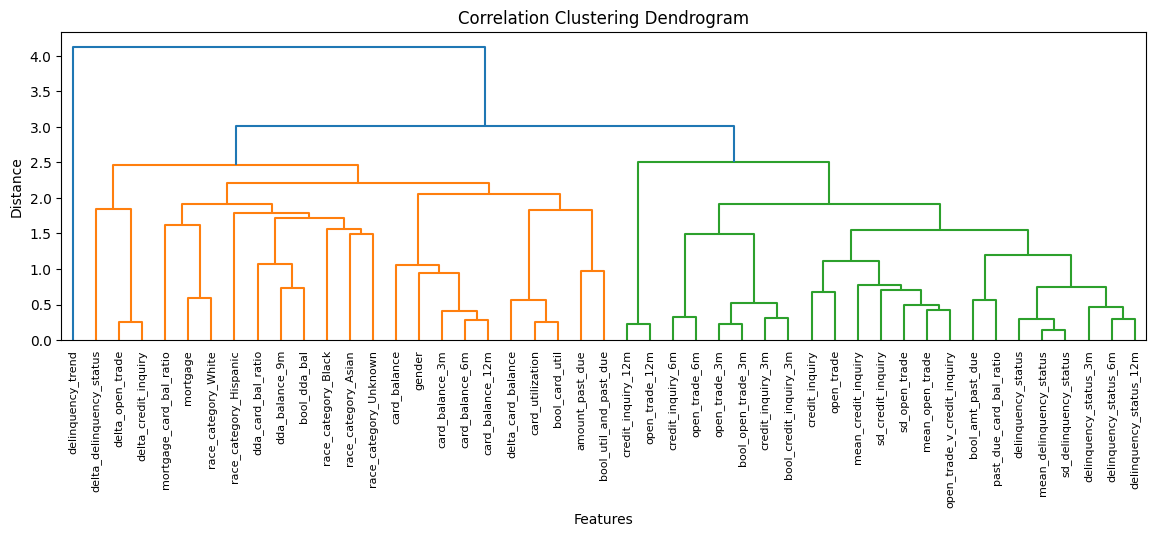

In [41]:
correlation_matrix = temp.drop('status', axis=1).corr()
linkage = hierarchy.linkage(correlation_matrix, method='average')

plt.figure(figsize=(14, 4))

dendrogram = hierarchy.dendrogram(linkage, labels=correlation_matrix.columns, leaf_rotation=90)

plt.title('Correlation Clustering Dendrogram')
plt.xlabel('Features')
plt.ylabel('Distance')
plt.xticks(rotation=90)
plt.show()

In [42]:
threshold = 1.5
cluster_labels = hierarchy.fcluster(linkage, threshold, criterion='distance')

clusters = {}
for feature, cluster_label in zip(correlation_matrix.columns, cluster_labels):
    if cluster_label not in clusters:
        clusters[cluster_label] = []
    clusters[cluster_label].append(feature)

for cluster_label, features in clusters.items():
    print(f'Cluster {cluster_label}: {features}')

Cluster 3: ['mortgage', 'race_category_White']
Cluster 10: ['card_utilization', 'bool_card_util', 'delta_card_balance']
Cluster 11: ['amount_past_due', 'bool_util_and_past_due']
Cluster 5: ['dda_balance_9m', 'bool_dda_bal', 'dda_card_bal_ratio']
Cluster 9: ['card_balance', 'card_balance_3m', 'card_balance_6m', 'card_balance_12m', 'gender']
Cluster 15: ['delinquency_status', 'delinquency_status_3m', 'delinquency_status_6m', 'delinquency_status_12m', 'mean_delinquency_status', 'sd_delinquency_status', 'bool_amt_past_due', 'past_due_card_bal_ratio']
Cluster 14: ['credit_inquiry', 'open_trade', 'mean_credit_inquiry', 'sd_credit_inquiry', 'mean_open_trade', 'sd_open_trade', 'open_trade_v_credit_inquiry']
Cluster 13: ['credit_inquiry_3m', 'credit_inquiry_6m', 'open_trade_3m', 'open_trade_6m', 'bool_credit_inquiry_3m', 'bool_open_trade_3m']
Cluster 12: ['credit_inquiry_12m', 'open_trade_12m']
Cluster 6: ['race_category_Asian', 'race_category_Unknown']
Cluster 7: ['race_category_Black']
Cluste

In [56]:
new_cols = [
    'mortgage', 'race_category_White', 'race_category_Asian', 'race_category_Hispanic',
    'bool_card_util', 'delta_card_balance',
    'bool_util_and_past_due', 'bool_dda_bal', 'dda_card_bal_ratio',
    'card_balance', 'card_balance_12m', 'gender',
    'delinquency_status', 'mean_delinquency_status',
    'mean_open_trade', 'sd_open_trade', 'open_trade_v_credit_inquiry',
    'bool_credit_inquiry_3m', 'bool_open_trade_3m',
    'mortgage_card_bal_ratio', 'delinquency_trend', 'delta_open_trade',
    'status'
]

Assorted Plots

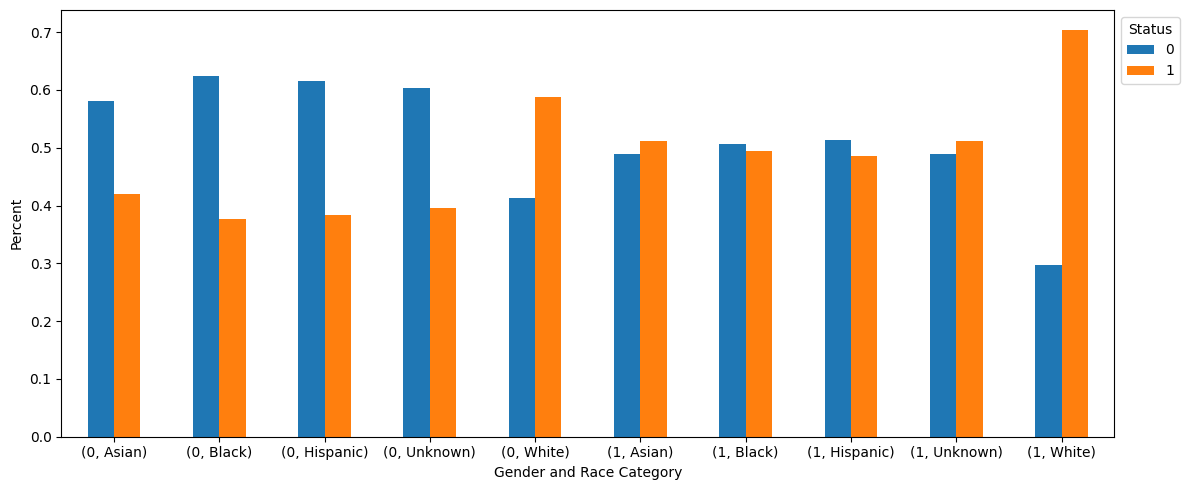

In [ ]:
ax = train.groupby(['Gender', 'Race_Category'])['Status'].value_counts(normalize=True).unstack().plot(
        kind='bar', figsize=(12, 5), xlabel='Gender and Race Category', ylabel='Percent', rot=0
    )

ax.legend(title='Status', bbox_to_anchor=(1, 1), loc='upper left')

plt.tight_layout()
plt.show()

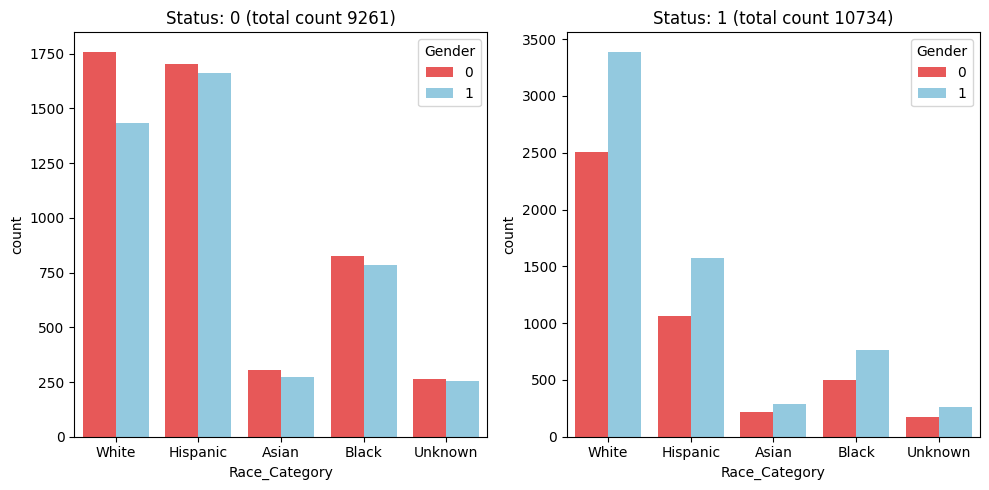

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

for (i, g), ax in zip(train.groupby('Status'), axes.flatten()):
    sns.countplot(g, x='Race_Category', hue='Gender', palette=['#ff4040', '#87CEEB'], ax=ax)
    ax.set_title(f'Status: {i} (total count {len(g)})')

plt.tight_layout()
plt.show()

In [ ]:
# Seems that the target labels are approximately evenly balanced.
# There is a bit of a gender imbalance in the sample of people with status label 1 (males over-represented in all race categories).

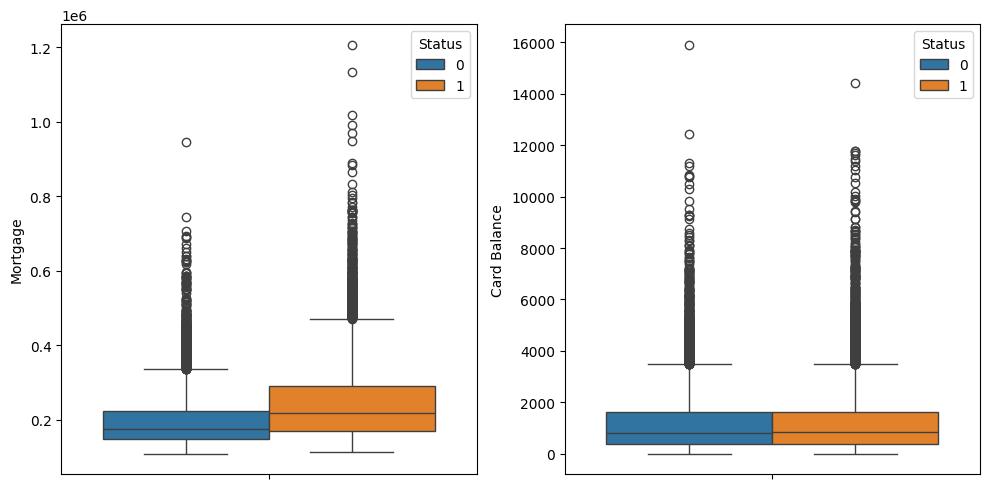

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

sns.boxplot(train, y='Mortgage', hue='Status', ax=ax[0])
sns.boxplot(train, y='Card Balance', hue='Status', ax=ax[1])

plt.tight_layout()
plt.show()

In [ ]:
# Higher mortgage may be a proxy for wealth and thus impact credit status.
# A high card balance may also be a proxy for wealth. On the other hand, it can mean that a person is struggling to make payments.

In [ ]:
# # train[ ['Card Balance_12m', 'Card Balance_6m', 'Card Balance_3m', 'Card Balance'] ]
# # train[ ['Credit Inquiry_12m', 'Credit Inquiry_6m', 'Credit Inquiry_3m', 'Credit Inquiry'] ]
# # train[ ['Delinquency Status_12m', 'Delinquency Status_6m', 'Delinquency Status_3m', 'Delinquency Status'] ]
# # train[ ['Open Trade_12m', 'Open Trade_6m', 'Open Trade_3m', 'Open Trade'] ]

# def compute_trend(row, lagged_var_name):
#     '''Checking if lags of a given variable for a given row (sample) 
#     are decreasing and/or staying the same over time (versus increasing).'''
    
#     curr_val = row[lagged_var_name]
    
#     for lag in ('3', '6', '12'):
#         col_name = f'{lagged_var_name}_{lag}m'
#         prior_val = row[col_name]
#         if prior_val < curr_val:
#             # prior value was smaller, meaning there is an increase!
#             return False
#         curr_val = prior_val
#     # did the lagged variable decrease (or at least stay the same)?
#     return True

# for col_name in ('Card Balance', 'Credit Inquiry', 'Open Trade', 'BPC'):
#     train[f'{col_name}_Decreasing'] = train.apply(compute_trend, axis=1, lagged_var_name=col_name)

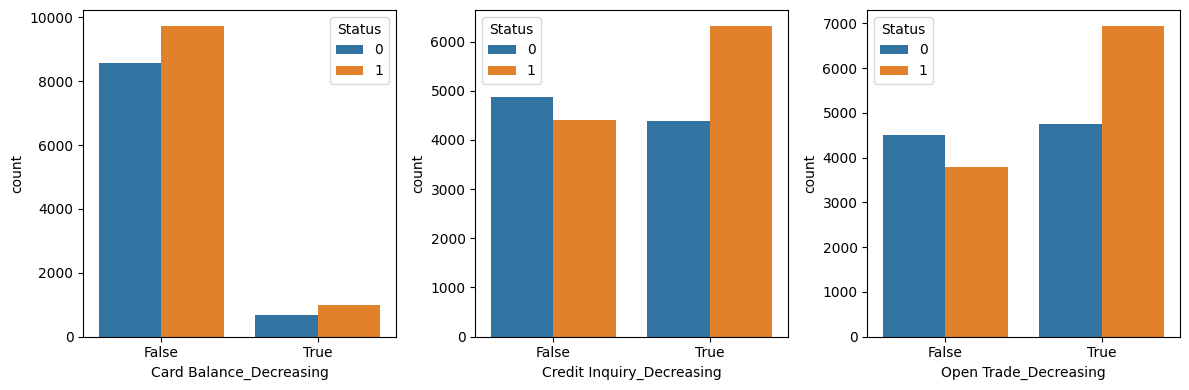

In [ ]:
# fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# for col_name, ax in zip(('Card Balance', 'Credit Inquiry', 'Open Trade'), axes.flatten()):
#     sns.countplot(train, x=f'{col_name}_Decreasing', hue='Status', ax=ax)

# plt.tight_layout()
# plt.show()

In [ ]:
# If there are fewer credit inquiries as well as accounts over time, perhaps a customer's financial situation is improving.
# However, if they are closing out their accounts, there is less of a chance to be delinquent (status of zero).

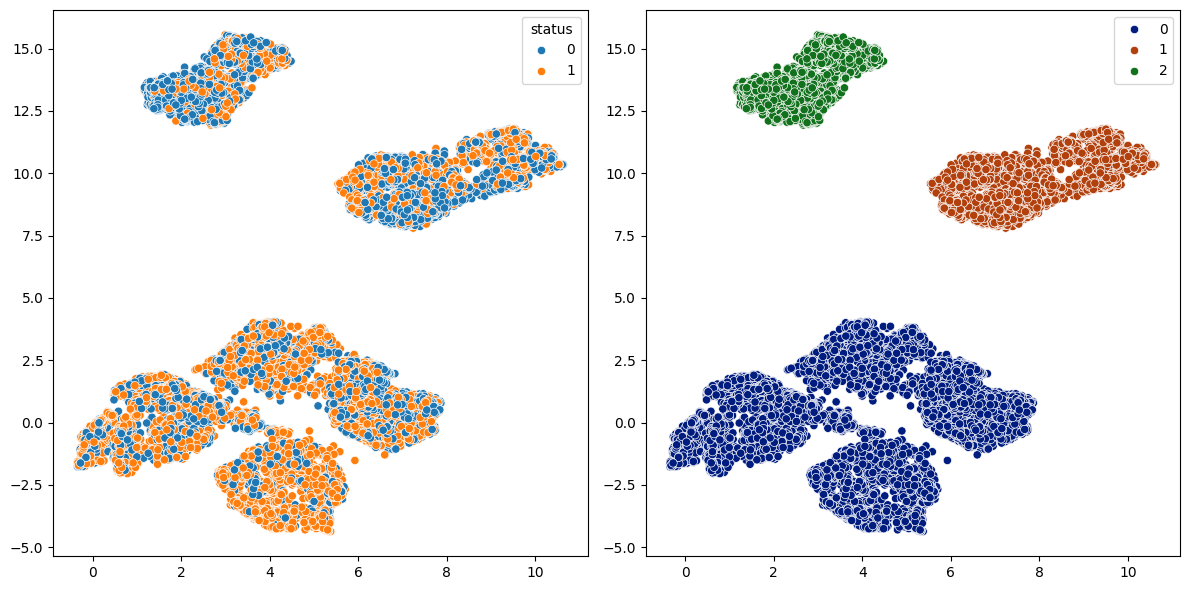

In [57]:
k = 2
umap_neighbors = 100

# standardizing features to mean 0 and unit variance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(temp[new_cols].drop('status', axis=1))
# computing UMAP embedding
reducer = umap.UMAP(n_neighbors=umap_neighbors, n_components=k, metric='canberra', init='random', verbose=False) # canberra, spectral?
embedding = reducer.fit_transform(X_scaled)#, axis=1)

clusterer = hdbscan.HDBSCAN(min_cluster_size=500, metric='euclidean').fit(embedding)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=temp['status'], ax=ax[0])
sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=clusterer.labels_, ax=ax[1], palette='dark')
plt.tight_layout()
plt.show()

In [59]:
temp['assgn'] = clusterer.labels_

In [60]:
temp[temp['assgn'].isin([0])]['status'].mean()

0.6495576771481124

In [62]:
temp[temp['assgn'].isin([2])]['status'].mean()

0.30592841163310963

In [ ]:
# Sanity check: we currently do not have good separation of the two classes based on features provided.